In [255]:
%load_ext autoreload

%autoreload 2

import gauleg as gl 
import sympy as sp 
import numpy as np 
import pandas as pd 
import math

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [256]:
# parameters to change

# def a0(x):
#     return 2 + math.sin(2*math.pi *x)

# def a0(x):
#     if 0 <= x < xd:
#         return 1
#     elif 0.5 <= x <= 1:
#         return 2

def a0(x):
    x = np.asarray(x)
    return np.where(x < 1/3, 2.0, np.where(x <= 2/3, 1.0, 2.0))


# def f(s):
#     if 0 <= s < 0.5:
#         return 2.0
#     elif 0.5 <= s <= 1:
#         return 4.0
    
# def f(s): 
#     return 2* (2 + math.sin(s)) - math.cos(s) *(1 -2*s)

# def f(s):
#     return 4 + 2 * math.sin(2 *math.pi *s) + (2*s-1) * 2* math.pi *math.cos(2*math.pi *s)
# def f(x):
#     x = np.asarray(x)
#     return np.where(x < xd, 4*np.pi**2 * np.sin(2*np.pi*x),
#                     8*np.pi**2 * np.sin(2*np.pi*x))
def f(x):
    x = np.asarray(x)
    # f(x) = a0(x)*pi^2*sin(pi*x)
    return a0(x) * np.pi**2 * np.sin(np.pi * x)

    


n2 = 5 # num of points for gauss legendre quadrature 


In [257]:
# helper functions
def GL(x_left, x_right, func):
    # Ensure xi and ci are NumPy arrays:
    xi, ci = np.polynomial.legendre.leggauss(n2)
    # Map the nodes from [-1,1] to [x_left, x_right]
    x_mapped = 0.5 * ((x_right - x_left) * xi + (x_right + x_left))
    # Evaluate the integrand at all mapped nodes (func must be vectorized or accept an array)
    integrand_values = func(x_mapped)
    # Compute the weighted sum using a dot-product and return the scaled result.
    return 0.5 * (x_right - x_left) * np.dot(ci, integrand_values)

def piecewise_GL(integrand, x_left, x_right, discont_points=None):
    """
    Integrate 'integrand(x)' from x_left to x_right using Gauss-Legendre quadrature,
    splitting the integration at any discontinuity points provided in discont_points.
    
    Parameters:
      integrand      : function to integrate, which must accept a NumPy array.
      x_left, x_right: the endpoints of the integration interval.
      n2             : number of Gauss–Legendre quadrature points.
      discont_points : a list (or scalar) of discontinuity points in (x_left, x_right).
                       If None or empty, no splitting is performed.
    
    Returns:
      The value of the integral.
    """
    # If no discontinuity is provided, do a single integration.
    if discont_points is None or len(discont_points) == 0:
        return GL(x_left=x_left, x_right=x_right, func=integrand)
    
    # Ensure discont_points is a list; if it's a scalar, convert it.
    if not isinstance(discont_points, (list, tuple, np.ndarray)):
        discont_points = [discont_points]
    
    # Filter out those discontinuity points that lie within (x_left, x_right)
    splits = [p for p in discont_points if x_left < p < x_right]
    
    # Build the list of subinterval endpoints
    pts = [x_left] + sorted(splits) + [x_right]
    
    # Integrate over each subinterval and sum the results.
    total = 0.0
    for i in range(len(pts) - 1):
        total += GL(x_left=pts[i], x_right=pts[i+1], func=integrand)
    return total

def dphi_i_on_element(i, k, xlist):
    """
    Return the (constant) slope of the i-th shape function on the k-th subinterval
    [ x_k, x_{k+1} ] in a 1D mesh with nodes x_0 < ... < x_N.
    """
    if i == k:
        # node i is the left endpoint of the subinterval => slope from 1 at x_k down to 0 at x_{k+1}
        dx = xlist[k+1] - xlist[k]
        return -1.0 / dx
    elif i == k+1:
        # node i is the right endpoint => slope from 0 at x_k up to 1 at x_{k+1}
        dx = xlist[k+1] - xlist[k]
        return +1.0 / dx
    else:
        return 0.0
def phi_i(i, x, mesh):
    """
    Standard 1D hat (finite element) function.
    This returns the value of the i-th hat function at x, given a mesh.
    """
    x = np.asarray(x)  # Ensure x is a NumPy array.
    N = len(mesh) - 1  # Number of elements; nodes are 0,1,...,N.
    
    if i == 0:
        # For the left boundary, phi_0 is nonzero on [mesh[0], mesh[1]]
        cond = (x >= mesh[0]) & (x <= mesh[1])
        return np.where(cond, (mesh[1] - x) / (mesh[1] - mesh[0]), 0.0)
    
    elif i == N:
        # For the right boundary, phi_N is nonzero on [mesh[N-1], mesh[N]]
        cond = (x >= mesh[N-1]) & (x <= mesh[N])
        return np.where(cond, (x - mesh[N-1]) / (mesh[N] - mesh[N-1]), 0.0)
    
    else:
        # For an interior node i, the support is [mesh[i-1], mesh[i+1]]
        cond = (x >= mesh[i-1]) & (x <= mesh[i+1])
        # On the left subinterval [mesh[i-1], mesh[i]]
        left_cond = (x >= mesh[i-1]) & (x <= mesh[i])
        left_val = (x - mesh[i-1]) / (mesh[i] - mesh[i-1])
        # On the right subinterval (mesh[i], mesh[i+1]]
        right_cond = (x > mesh[i]) & (x <= mesh[i+1])
        right_val = (mesh[i+1] - x) / (mesh[i+1] - mesh[i])
        # Combine the two pieces:
        val = np.where(left_cond, left_val, np.where(right_cond, right_val, 0.0))
        return np.where(cond, val, 0.0)



In [258]:
# assembly of matrix S0 and F
def S0_ji(func, mesh):
    N = len(mesh)
    S0_mat = sp.zeros(N, N)
    # assembly of diagonal entries of S0 
    for j in range(N):
            diag_val = 0.0
            # Contribution from the left subinterval [mesh[j-1], mesh[j]]
            if j > 0:
                x_left = mesh[j-1]
                x_right = mesh[j]
                # On [mesh[j-1], mesh[j]], phi_j is the right (increasing) part.
                def integrand_left(x):
                    # dphi_j/dx on [mesh[j-1], mesh[j]]:
                    return func(x) * (dphi_i_on_element(j, j-1, mesh))**2
                diag_val += piecewise_GL(integrand_left, x_left, x_right, [1/3, 2/3])
                
            # Contribution from the right subinterval [mesh[j], mesh[j+1]]
            if j < N-1:
                x_left = mesh[j]
                x_right = mesh[j+1]
                # On [mesh[j], mesh[j+1]], phi_j is the left (decreasing) part.
                def integrand_right(x):
                    # dphi_j/dx on [mesh[j], mesh[j+1]]:
                    return func(x) * (dphi_i_on_element(j, j, mesh))**2
                diag_val += piecewise_GL(integrand_right, x_left, x_right, [1/3, 2/3])
                
            S0_mat[j, j] = diag_val

    for j in range(1, N):
        # Contribution for S1[j, j-1] (and by symmetry S1[j-1, j]) over [mesh[j-1], mesh[j]]
        x_left = mesh[j-1]
        x_right = mesh[j]
        def integrand_off(x):
            # For node j-1 on the element, phi_{j-1} is the left (decreasing) part,
            # and for node j, phi_j is the right (increasing) part.
            return func(x) * dphi_i_on_element(j-1, j-1, mesh) * dphi_i_on_element(j, j-1, mesh)
        val = piecewise_GL(integrand_off, x_left, x_right, [1/3, 2/3])
        S0_mat[j, j-1] = val
        S0_mat[j-1, j] = val  # Exploiting symmetry
    
    return S0_mat
        


def build_force_vector(f, mesh, n2=5):
    """
    Assemble the force (load) vector F where
         F[i] = ∫ f(x) * phi_i(x) dx,
    computed by integrating over the support of the i-th finite element function.
    
    Parameters:
      f     : The source function, f(x).
      mesh  : A list of node coordinates, e.g. [x0, x1, ..., xN].
      n2    : Number of Gauss-Legendre points.
      
    Returns:
      F     : A column vector (Sympy Matrix) of size (N+1) x 1.
    """
    num_nodes = len(mesh)  # = N+1
    F = sp.zeros(num_nodes, 1)
    
    # Loop over each finite element function phi_i.
    for i in range(num_nodes):
        total = 0.0
        
        # The support of phi_i:
        # For interior nodes, the support is [mesh[i-1], mesh[i+1]] split into two intervals.
        # For the left boundary, support is [mesh[0], mesh[1]].
        # For the right boundary, support is [mesh[-2], mesh[-1]].
        
        # Left subinterval (if it exists)
        if i > 0:
            x_left  = mesh[i-1]
            x_right = mesh[i]
            def integrand_left(x):
                return f(x) * phi_i(i, x, mesh)
            total += piecewise_GL(integrand_left, x_left, x_right, [1/3, 2/3])
        
        # Right subinterval (if it exists)
        if i < num_nodes - 1:
            x_left  = mesh[i]
            x_right = mesh[i+1]
            def integrand_right(x):
                return f(x) * phi_i(i, x, mesh)
            total += piecewise_GL(integrand_right, x_left, x_right, [1/3, 2/3])
        
        F[i, 0] = total

    return F

In [259]:
def extract_interior(S, F):
    S_int = S[1:-1, 1:-1]
    F_int = F[1:-1, :]

    return S_int, F_int

def c(S_int, F_int):
    S_int_np = np.array(S_int.tolist(), dtype=np.float64)
    F_int_np = np.array(F_int.tolist(), dtype=np.float64)
    sol = np.linalg.solve(S_int_np.T, F_int_np)
    return sol


In [260]:
def approx_new(c, F):
    approx_new = c.T *F

    return approx_new[0,0]

def energy_norm(approximation):
    # actual = 0.6146
    # actual = 0.8146667469752307
    actual = 0.5
    energy_norm = actual - approximation
    return energy_norm

In [261]:


def assemble_nodal_values(C):
    C = np.asarray(C)  # Ensure C is a NumPy array.
    return np.concatenate(([[0.0]], C, [[0.0]]))


In [262]:
import matplotlib.pyplot as plt
def solve(l):
    mesh = np.linspace(0, 1, 2**l + 1)
    S0_sym = S0_ji(a0, mesh)         # Possibly a Sympy matrix
    fvect_sym = build_force_vector(f, mesh, 5)  # Possibly a Sympy matrix

    # Convert to NumPy float arrays:
    S0 = np.array(S0_sym.tolist(), dtype=np.float64)
    fvect = np.array(fvect_sym.tolist(), dtype=np.float64)
    
    s_int_sym, f_int_sym = extract_interior(S0_sym, fvect_sym)
    # Convert interior matrices:
    s_int = np.array(s_int_sym.tolist(), dtype=np.float64)
    f_int = np.array(f_int_sym.tolist(), dtype=np.float64)
    
    c_sol = c(s_int, f_int)  # c() now works on numeric arrays
    nodal = assemble_nodal_values(c_sol)
    x_nodal = np.array(mesh, dtype=float)
    u_nodal = np.array(nodal, dtype=float)
    
    approximation = approx_new(c_sol, f_int)
    enorm = energy_norm(approximation)

    # def exact_solution(x):
    #     return x*(1.0 - x)

    # print(u_nodal)
    # plt.plot(x_nodal, u_nodal, marker='o', linestyle='-', color='blue', label='Numerical (Refined Mesh)')
    
    # x_fine = np.linspace(0.0, 1.0, 200)
    # u_exact = exact_solution(x_fine)
    # plt.plot(x_fine, u_exact, color='red', linewidth=2, label='Exact: x(1-x)')
    
    # plt.xlabel('x')
    # plt.ylabel('u(x)')
    # plt.title('Refined Numerical Solution vs. Exact')
    # plt.grid(True)
    # plt.legend()
    # plt.show()
    
    return enorm, S0, fvect


In [263]:
solve(2)[1]


array([[ 8.        , -8.        ,  0.        ,  0.        ,  0.        ],
       [-8.        , 13.33333333, -5.33333333,  0.        ,  0.        ],
       [ 0.        , -5.33333333, 10.66666667, -5.33333333,  0.        ],
       [ 0.        ,  0.        , -5.33333333, 13.33333333, -8.        ],
       [ 0.        ,  0.        ,  0.        , -8.        ,  8.        ]])

In [264]:
solve(2)[2]

array([[0.62633106],
       [2.80240933],
       [2.56729718],
       [2.80240933],
       [0.62633106]])

In [265]:
def solve_scF_once(mesh):
    """
    Build and solve the system S*C = F for a single iteration.

    Parameters
    ----------
    n_list, m_list : lists of indices (e.g. polynomial degrees)
    i_list         : indices for the piecewise-constant or piecewise-linear basis

    Returns
    -------
    C : Sympy Matrix
        The solution vector for the unknowns.
    """

    S0_sym = S0_ji(a0, mesh)         # Possibly a Sympy matrix
    fvect_sym = build_force_vector(f, mesh, 5)  # Possibly a Sympy matrix

    # Convert to NumPy float arrays:
    S0 = np.array(S0_sym.tolist(), dtype=np.float64)
    fvect = np.array(fvect_sym.tolist(), dtype=np.float64)
    
    s_int_sym, f_int_sym = extract_interior(S0_sym, fvect_sym)
    # Convert interior matrices:
    s_int = np.array(s_int_sym.tolist(), dtype=np.float64)
    f_int = np.array(f_int_sym.tolist(), dtype=np.float64)
    
    c_sol = c(s_int, f_int)  # c() now works on numeric arrays
    

    return c_sol, fvect

In [266]:

# def r(mesh, e):
#     """
#     Compute an approximation to the cell residual on element T = [mesh[e], mesh[e+1]].
#     Since u_h is piecewise linear and a0 is constant on T (if T does not cross x=1/3),
#     the derivative term is zero and we approximate r(x) by f(x).
#     """
#     a, b = mesh[e], mesh[e+1]
#     # Use a vectorized quadrature routine to approximate the L2 norm of f over T.
#     rT = GL(a, b, f) / (b - a)
#     return rT

def r(x, mesh, uh):
    # 'uh' and 'mesh' not strictly needed to compute a'(x), since a'(x)=0 except at 0.5.
    # The interior PDE says r(x) = f(x) + slope*a'(x). But a'(x)=0 almost everywhere,
    # so r(x) is just f(x).
    x = np.asarray(x)
    # f(x) = a0(x)*pi^2*sin(pi*x)
    return a0(x) * np.pi**2 * np.sin(np.pi * x)

def element_residual_l2(mesh, e):
    """
    Compute the L2 norm squared of the cell residual on element T = [mesh[e], mesh[e+1]].
    Since r(x) is constant on T, the L2 norm squared is (r_T)^2 * h.
    """
    a, b = mesh[e], mesh[e+1]
    h = b - a
    
    # Define an integrand that accepts the integration variable.
    def interior_integrand(x_val):
        # r(x) is defined as f(x) here; you can pass extra arguments if needed.
        return r(x_val, None, None)**2

    # Use your piecewise_GL routine to integrate the squared residual over [a, b].
    r_sq = piecewise_GL(interior_integrand, x_left=a, x_right=b, discont_points=[1/3, 2/3])
    return r_sq


def slope_at_node(mesh, uh, i, side):
    """
    Return the slope of the piecewise-linear FE solution uh on the element
    adjacent to node i from the given side ('left' or 'right').
    """
    n = len(mesh) - 1
    if side == 'left':
        if i == 0:
            return 0.0
        else:
            dx = mesh[i] - mesh[i-1]
            return (uh[i] - uh[i-1]) / dx
    elif side == 'right':
        if i >= n:
            return 0.0
        else:
            dx = mesh[i+1] - mesh[i]
            return (uh[i+1] - uh[i]) / dx
    else:
        raise ValueError("side must be 'left' or 'right'.")

def flux_jump(mesh, uh, i, a0_func):
    """
    Compute the jump in the numerical flux at the node mesh[i] (assumed interior).
    The flux is sigma = a0 * (approximate derivative), with the sign convention:
       sigma_left  = a0(x_i^-) * slope on [x_{i-1}, x_i],
       sigma_right = a0(x_i^+) * slope on [x_i, x_{i+1}].
    The jump is defined as: j(x_i) = sigma_right - sigma_left.
    
    Parameters:
      mesh    : array of node coordinates.
      uh      : array of nodal values of the FE solution.
      i       : the index of an interior node.
      a0_func : a vectorized coefficient function.
    
    Returns:
      jump    : the flux jump at node i.
    """
    # For an interior node, compute the slopes on the left and right.
    slope_left = slope_at_node(mesh, uh, i, 'left')
    slope_right = slope_at_node(mesh, uh, i, 'right')
    # Evaluate a0 on either side. To avoid ambiguity at discontinuities, we use a small perturbation.
    a_left  = a0_func(mesh[i] - 1e-9)
    a_right = a0_func(mesh[i] + 1e-9)
    sigma_left  = a_left * slope_left
    sigma_right = a_right * slope_right
    return sigma_right - sigma_left

def sum_of_error(i, mesh, nodal):
    x_left_element_i= mesh[i]
    x_right_element_i = mesh[i+1]
    h = x_right_element_i - x_left_element_i
    residual_sq = element_residual_l2(mesh, i)
    boundary_sq = flux_jump(mesh, nodal, i, a0) **2
    return h ** 2 * residual_sq + h * boundary_sq

def sum_of_error_list(mesh, nodal):
    return [sum_of_error(i, mesh, nodal) for i in range(len(mesh) - 1)]
def refine_mesh(mesh, element_index):
    """
    Refine the element [mesh[element_index], mesh[element_index+1]] by bisection.
    """
    x_left = mesh[element_index]
    x_right = mesh[element_index+1]
    midpoint = 0.5 * (x_left + x_right)
    # Insert the midpoint after mesh[element_index]
    return mesh[:element_index+1] + [midpoint] + mesh[element_index+1:]


def element_selection(errors, epsilon):
    """
    Given an array-like 'errors' (one error per element) and a tolerance epsilon,
    return a list of element indices to refine (sorted in descending order).
    """
    errors = np.asarray(errors)
    # Find all indices where error exceeds epsilon.
    indices = np.nonzero(errors > epsilon)[0]
    # Sort in descending order so that when refining, index shifts are avoided.
    indices = np.sort(indices)[::-1]
    return indices.tolist()

def element_refinement(mesh, element_indices):
    """
    Refine the given 1D mesh by bisection on all elements whose indices are provided in
    element_indices. The new mesh is the sorted union of the original nodes and the midpoints.
    
    Parameters:
      mesh            : list or array of node coordinates (assumed sorted).
      element_indices : list or array of element indices (each index i corresponds to element [mesh[i], mesh[i+1]])
    
    Returns:
      new_mesh        : a sorted list of node coordinates including the midpoints for refined elements.
    """
    mesh_arr = np.array(mesh)
    element_indices = np.array(element_indices, dtype=int)
    
    # Compute midpoints for each marked element.
    midpoints = 0.5 * (mesh_arr[element_indices] + mesh_arr[element_indices + 1])
    
    # Concatenate the original mesh with the new midpoints, then sort.
    new_mesh = np.sort(np.concatenate((mesh_arr, midpoints)))
    return new_mesh.tolist()



In [267]:
def refinement_loop(epsilon):
    """
    1) Start with initial mesh
    2) Solve once
    3) Estimate errors
    4) If all errors < epsilon, done. Else refine, go back to step 2.
    """
    mesh = [0, 0.5, 1]

    # Keep track of (mesh, energy_norm) in each iteration
    enorm_history = []
    iteration_index = 0
    while True:
        # Solve for c_sol on the current mesh
        c_sol, f_sol = solve_scF_once(mesh=mesh)

        # Convert solution to nodal representation
        nodal = assemble_nodal_values(c_sol)

        # Estimate the elementwise errors
        errors = sum_of_error_list(mesh=mesh, nodal=nodal)

        # Mark which elements to refine
        elements_to_refine = element_selection(errors=errors, epsilon=epsilon)
        # elements_to_refine = dorfler_marking(errors, 0.2)


        # For logging: compute the “approximation” and an “energy norm”
        approximation = approx_new(c=c_sol, F=f_sol)
        enorm = energy_norm(approximation)

        # Record in the history: current mesh + energy norm
        enorm_history.append((iteration_index, enorm))

        # If no elements exceed threshold => done
        if not elements_to_refine:
            break

        # Otherwise refine
        mesh = element_refinement(mesh, elements_to_refine)
        iteration_index += 1
        print("Refined mesh:", mesh)

    # After loop, final solution is c_sol on final mesh
    # Return everything, including the entire history
    return mesh, c_sol, enorm_history


Refined mesh: [0.0, 0.25, 0.5, 0.75, 1.0]
Refined mesh: [0.0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1.0]
Refined mesh: [0.0, 0.0625, 0.125, 0.1875, 0.25, 0.3125, 0.375, 0.4375, 0.5, 0.5625, 0.625, 0.6875, 0.75, 0.8125, 0.875, 0.9375, 1.0]
Refined mesh: [0.0, 0.03125, 0.0625, 0.09375, 0.125, 0.15625, 0.1875, 0.21875, 0.25, 0.28125, 0.3125, 0.34375, 0.375, 0.40625, 0.4375, 0.46875, 0.5, 0.53125, 0.5625, 0.59375, 0.625, 0.65625, 0.6875, 0.71875, 0.75, 0.78125, 0.8125, 0.84375, 0.875, 0.90625, 0.9375, 0.96875, 1.0]
Refined mesh: [0.0, 0.015625, 0.03125, 0.0625, 0.078125, 0.09375, 0.109375, 0.125, 0.140625, 0.15625, 0.171875, 0.1875, 0.203125, 0.21875, 0.234375, 0.25, 0.265625, 0.28125, 0.296875, 0.3125, 0.328125, 0.34375, 0.359375, 0.375, 0.390625, 0.40625, 0.421875, 0.4375, 0.453125, 0.46875, 0.484375, 0.5, 0.515625, 0.53125, 0.546875, 0.5625, 0.578125, 0.59375, 0.609375, 0.625, 0.640625, 0.65625, 0.671875, 0.6875, 0.703125, 0.71875, 0.734375, 0.75, 0.765625, 0.78125, 0.796875, 0.8

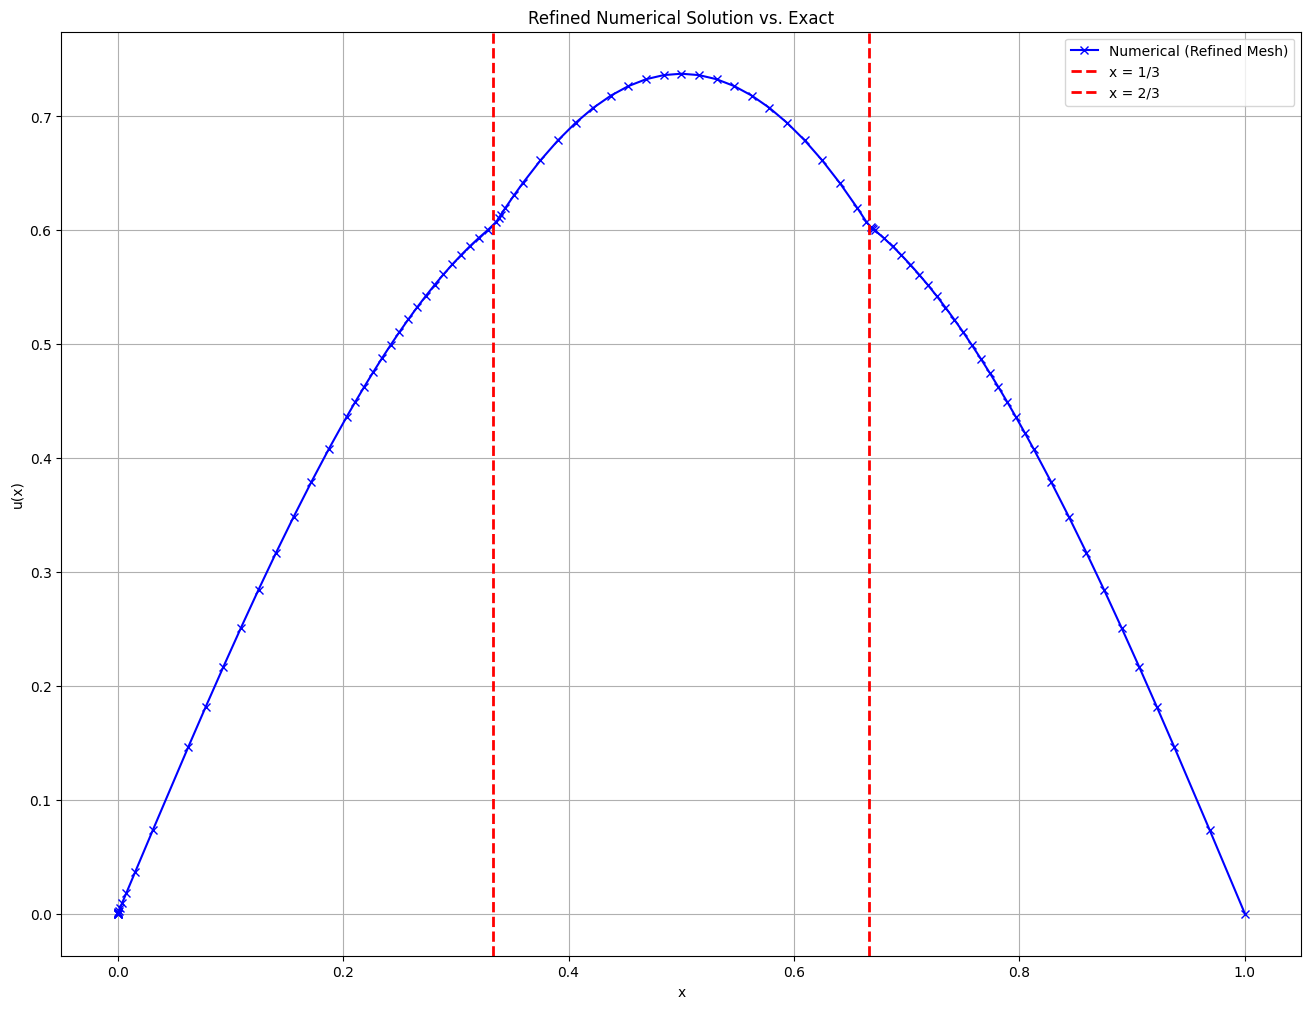

In [271]:
import numpy as np
import matplotlib.pyplot as plt


mesh, c_sol, enorm_history = refinement_loop(epsilon=0.001)


nodal = assemble_nodal_values(c_sol)  

x_nodal = np.array(mesh, dtype=float)
u_nodal = np.array(nodal, dtype=float)

# Define the exact solution
def exact_solution(x):
    x = np.asarray(x)
    return np.sin(np.pi*x)

# We'll plot the exact solution on a fine grid from 0..1
x_fine = np.linspace(0.0, 1.0, 200)
u_exact = exact_solution(x_fine)

plt.figure(figsize=(16,12))

# 1) Plot the piecewise-linear solution
plt.plot(
    x_nodal,
    u_nodal,
    marker='x',
    linestyle='-',
    color='blue',
    label='Numerical (Refined Mesh)'
)

# # 2) Plot the exact solution as a smooth curve
# plt.plot(
#     x_fine,
#     u_exact,
#     color='red',
#     linewidth=2,
#     label='Exact: sin(pi x)'
# )
plt.axvline(x=1/3, color='r', linestyle='--', linewidth=2, label="x = 1/3")
plt.axvline(x=2/3, color='r', linestyle='--', linewidth=2, label="x = 2/3")
plt.xlabel('x')
plt.ylabel('u(x)')
plt.title('Refined Numerical Solution vs. Exact')
plt.grid(True)
plt.legend()
plt.show()
